In [12]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, pmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="1"
jax.devices()

[CpuDevice(id=0)]

# Multi-Time Scale XNOR Dataset debug
---

In [13]:
from utils_initialization import SimArgs
args = SimArgs()
args.dataset_name = 'mts_xor'
args.n_epochs = 25

from utils_dataset import get_dataloader
train_dl, val_dl, test_dl = get_dataloader( args=args )

In [14]:
x, y = next(iter(train_dl))

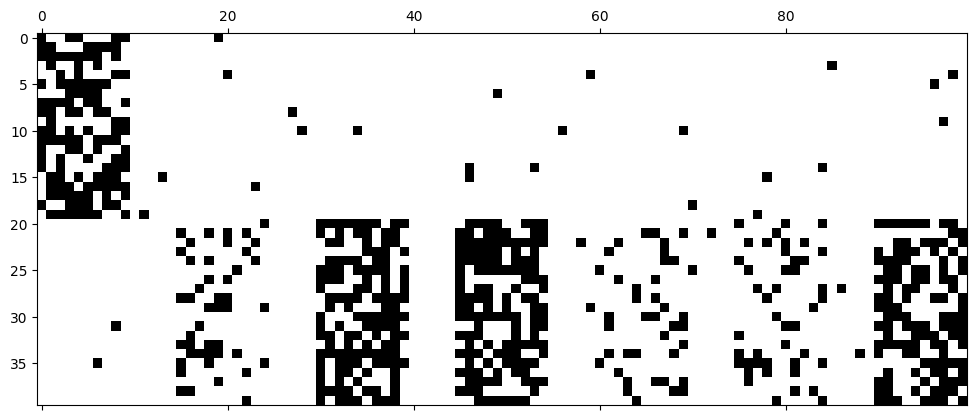

In [23]:
_ = plt.matshow( x[7].T, cmap='Grays' )

In [15]:
def one_hot(x, n_class):
    if args.dataset_name == 'mts_xor':
        return jnp.array(x[:,:, None] == jnp.arange(n_class), dtype=jnp.float32)
    else:
        return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

In [10]:
batch_size=256
n_epochs=150
nb_steps=100 
channel=2; channel_rate=[0.2, 0.6] 
noise_rate=0.01; channel_size=20
coding_time=10; remain_time=5; 
start_time=10; verbose=False

idx = []
for i in range(100):
    if (((i-start_time) % (coding_time+remain_time)) >= remain_time)and(i>start_time):
        #print(i)
        idx.append(i)
len( idx )

60

## Parameters of the SNN model
---

In [2]:
from utils_initialization import args

## Download and Import the SHD dataset
---

In [10]:
args.dataset_name = 'ssc'
from utils_dataset import get_dataloader
train_loader_custom_collate, val_loader_custom_collate, test_loader_custom_collate = get_dataloader( args=args, verbose=True )

Train DL size: 75466, Validation DL size: 9981, Test DL size: 20382


In [11]:
x, y = next( iter( train_loader_custom_collate ) )

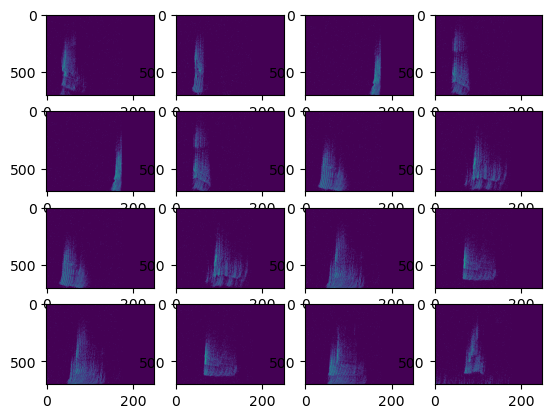

In [12]:
ver, hor = 4, 4
fig, ax = plt.subplots( ver, hor )
for i in range(ver):
    for j in range(hor):
        ax[i,j].imshow( x[j+i*2].T, aspect='auto' )

In [13]:
x, y = next( iter( val_loader_custom_collate ) )

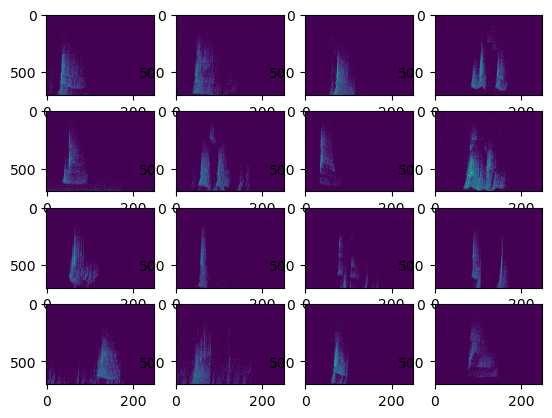

In [14]:
ver, hor = 4, 4
fig, ax = plt.subplots( ver, hor )
for i in range(ver):
    for j in range(hor):
        ax[i,j].imshow( x[j+i*hor].T, aspect='auto' )

In [15]:
x, y = next( iter( test_loader_custom_collate ) )

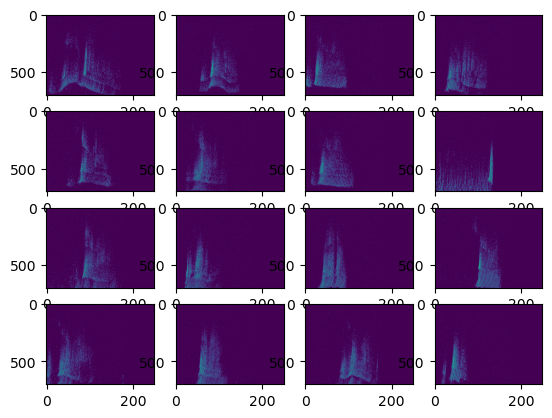

In [16]:
ver, hor = 4, 4
fig, ax = plt.subplots( ver, hor )
for i in range(ver):
    for j in range(hor):
        ax[i,j].imshow( x[j+i*hor].T, aspect='auto' )

Our Dataloader
Mean Firing Rate on Test set: 0.1174876764294733
Channels 0-100 Firing rate: 0.00706328125
Channels 100-200 Firing rate: 0.010424175347222222
Channels 200-300 Firing rate: 0.029488557449494954
Channels 300-400 Firing rate: 0.08849810606060604
Channels 400-500 Firing rate: 0.20145490451388887
Channels 500-600 Firing rate: 0.29815841619318184
Channels 600-700 Firing rate: 0.18732629419191915


/Users/filippomoro/Documents/hsnn/spikin_datasets.py:75: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  x = torch.sparse.FloatTensor(x_idx, x_val, x_size).to(self.device)



Bittar Dataloader
Mean Firing Rate on Test set: 0.11748767644166946
Channels 0-100 Firing rate: 0.00706328172236681
Channels 100-200 Firing rate: 0.01042417623102665
Channels 200-300 Firing rate: 0.02948855422437191
Channels 300-400 Firing rate: 0.08849810808897018
Channels 400-500 Firing rate: 0.20145492255687714
Channels 500-600 Firing rate: 0.2981584072113037
Channels 600-700 Firing rate: 0.18732629716396332


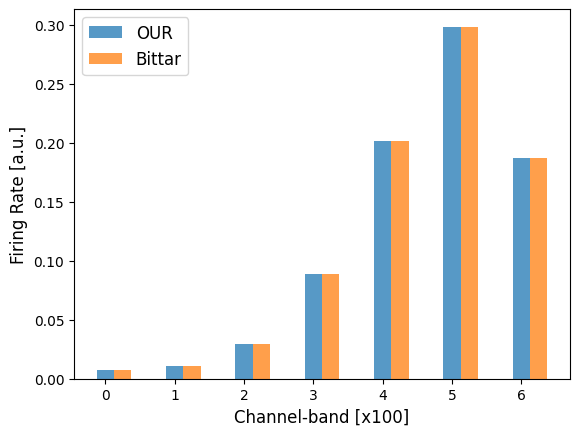

In [4]:
mean_spikes = []
for step, (x, y) in enumerate(test_loader_custom_collate):
    mean_spikes.append( x.mean(axis=(0,1)) )
mean_activity = np.mean(mean_spikes, axis=0)
# np.mean( mean_activity ), np.max(mean_activity), np.min(mean_activity), mean_activity.shape

print('Our Dataloader')
print(f'Mean Firing Rate on Test set: {np.mean( mean_activity )}')
act_channels = []
for i in range(7):
    print( f'Channels {i*100}-{(i+1)*100} Firing rate: { np.mean( mean_activity[i*100:(i+1)*100] ) }' )
    act_channels.append( np.mean( mean_activity[i*100:(i+1)*100] ) )


# Loading dataloader from Bittar
from spikin_datasets import load_shd_or_ssc
test_loader_sparch = load_shd_or_ssc( 
    dataset_name = 'shd',
    data_folder = '/Users/filippomoro/Desktop/KINGSTONE/Datasets/SHD/audiospikes',
    split = 'test',
    batch_size = 128,
    nb_steps=100,
    shuffle=False,
    workers=0,
 )

mean_spikes_bittar = []
for step, (x, y) in enumerate(test_loader_sparch):
    mean_spikes_bittar.append( x.mean(axis=(0,1)) )
mean_activity_bittar = np.mean(mean_spikes_bittar, axis=0)
# np.mean( mean_activity ), np.max(mean_activity), np.min(mean_activity), mean_activity.shape
print('\nBittar Dataloader')
print(f'Mean Firing Rate on Test set: {np.mean( mean_activity_bittar )}')
act_channels_bittar = []
for i in range(7):
    print( f'Channels {i*100}-{(i+1)*100} Firing rate: { np.mean( mean_activity_bittar[i*100:(i+1)*100] ) }' )
    act_channels_bittar.append( np.mean( mean_activity_bittar[i*100:(i+1)*100] ) )

fig, ax = plt.subplots( )
ax.bar( np.arange(7), act_channels, alpha=0.75, width=0.25, label='OUR' )
ax.bar( np.arange(7)+0.25, act_channels_bittar, alpha=0.75, width=0.25, label='Bittar' )
ax.set_ylabel('Firing Rate [a.u.]', size=12)
ax.set_xlabel('Channel-band [x100]', size=12)
ax.legend(prop={'size':12})

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
from spikin_datasets import SpikingDataset
from torch.utils.data import DataLoader
from utils_dataset import custom_collate_fn

# import dataset
train_ds = SpikingDataset('shd', '/Users/filippomoro/Desktop/KINGSTONE/Datasets/SHD/audiospikes', 'train', args.nb_steps) # print(len(train_ds[0]))
test_ds  = SpikingDataset('shd', '/Users/filippomoro/Desktop/KINGSTONE/Datasets/SHD/audiospikes', 'test', args.nb_steps) # print(len(train_ds[0]))

# Set random seeds for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

train_size = int(0.99 * len(train_ds))
val_size   = len(train_ds) - train_size
# train_ds_split = train_ds
train_ds_split, val_ds_split = random_split(train_ds, [train_size, val_size])
print(f'Train DL size: {len(train_ds)}, Validation DL size: {len(val_ds_split)}, Test DL size: {len(test_ds)}')

train_loader_custom_collate = DataLoader(train_ds_split, args.batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader_custom_collate   = DataLoader(val_ds_split,   args.batch_size, shuffle=None, collate_fn=custom_collate_fn)
test_loader_custom_collate  = DataLoader(test_ds,        args.batch_size, shuffle=None, collate_fn=custom_collate_fn)

# MNIST-debug
---

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
from utils_dataset import custom_collate_fn
import torchvision

In [3]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T

def expand_time_dim( data, nb_steps=100 ):
    times = current2firing_time( data )
    data_time = np.zeros( (data.shape[0], nb_steps, data.shape[-1]), dtype=np.uint8 )
    bs, ids = np.where( times.numpy().astype(int) != 1 )
    data_time[bs, np.clip( times.numpy().astype(int)[bs, ids], 0, nb_steps-1), ids] = 1
    return  data_time

In [2]:
root = '/home/filippo/data/audiospikes'
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

train_dataset.data  = expand_time_dim( train_dataset.data.reshape( train_dataset.data.shape[0], -1 )/255., nb_steps=100 )
test_dataset.data   = expand_time_dim( test_dataset.data.reshape( test_dataset.data.shape[0], -1 )/255., nb_steps=100 )

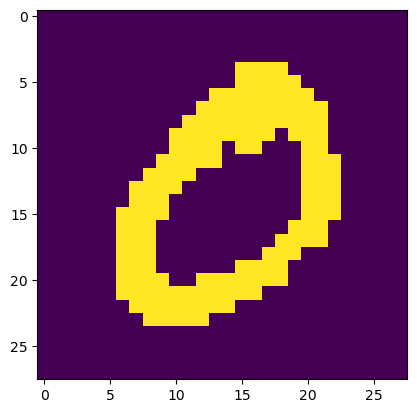

In [9]:
import matplotlib.pyplot as plt
# plt.imshow( times[0] )
plt.imshow( test_dataset.data[1].sum(0).reshape(28,28) )

In [5]:
from utils_initialization import SimArgs
args = SimArgs()
args.dataset_name = 'mnist'
args.n_epochs = 25
args.nb_steps = 50

from utils_dataset import get_dataloader
train_dl, val_dl, test_dl = get_dataloader( args=args )

In [6]:
x, y = next( iter( train_dl ) )

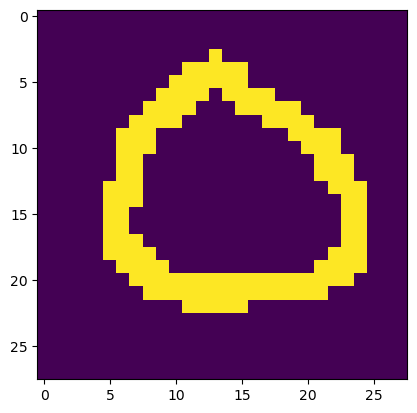

In [17]:
import matplotlib.pyplot as plt
# plt.imshow( times[0] )
plt.imshow( x[11].sum(0).reshape(28,28) )

In [5]:
from utils_initialization import SimArgs
args = SimArgs()
args.dataset_name = 'ps-mnist'
args.n_epochs = 25
args.nb_steps = 50

from utils_dataset import get_dataloader
train_dl, val_dl, test_dl = get_dataloader( args=args )

x, y = next( iter( train_dl ) )

In [6]:
x.shape

(256, 784, 1)

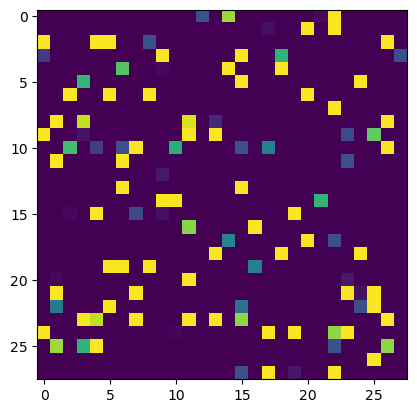

In [7]:
import matplotlib.pyplot as plt
plt.imshow( x[0].reshape(28, 28) )

# Importing the model
---

In [5]:
from models import *
from utils_initialization import *

In [ ]:
def lif_step( args_in, input_spikes ):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # V_mem = (alpha) * (V_mem - out_spikes) + (1-alpha) * I_in #- out_spikes*v_thr
    # V_mem = (alpha) * (V_mem - out_spikes) + I_in #- out_spikes*v_thr
    V_mem = alpha * V_mem + input_spikes - out_spikes*v_thr
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], out_spikes


# Leaky Integrate and Fire layer, Recurrent
def rlif_step( args_in, input_spikes):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states
    win_mask, wrec_mask = w_mask
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    win, wrec = weight
    w_rec_diag_zeros = jnp.ones_like(wrec) - jnp.eye( wrec.shape[0] )

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_rec = jnp.matmul(out_spikes, wrec*wrec_mask*w_rec_diag_zeros)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = alpha * V_mem + input_spikes + I_rec - out_spikes*v_thr
    # V_mem = alpha * (V_mem - out_spikes) + (1-alpha) * ( I_in_norm )
    # V_mem = alpha * (V_mem - out_spikes) + (1) * ( I_in_norm )
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], out_spikes

# Leaky Integrator (output layer)
def li_step(args_in, input_spikes):
    ''' Forward function for the Leaky-Integrator neuron layer, adopted here for the output layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (inputs and membrane)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LI formula, Euler approximation
    V_mem = (alpha) * (V_mem) + (1-alpha) * input_spikes
    # V_mem = (alpha) * (V_mem) + input_spikes
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], V_mem

# parallelizing the Single Layer
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in
    n_layers = len( net_params )
    # collection of output spikes
    out_spike_net = []
    # Loop over the layers
    for l in range(n_layers):
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # we evolve the state of the neuron according to the LIF formula, Euler approximation
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net


In [ ]:
plt.imshow( out_spikes_layer[0].T )

In [ ]:
plt.imshow( I_in[0].T )

In [ ]:
plt.imshow( out_spikes_vlayer[10].T )

## Normalization Layer debug

In [6]:
from models import *
from utils_initialization import *

In [8]:
# Normalization Layers
from typing import (Any, Callable, Iterable, Optional, Tuple, Union)

PRNGKey = Any
Array = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?

Axes = Union[int, Iterable[int]]

def _canonicalize_axes(rank: int, axes: Axes) -> Tuple[int, ...]:
    """Returns a tuple of deduplicated, sorted, and positive axes."""
    if not isinstance(axes, Iterable):
        axes = (axes,)
    return tuple(set([rank + axis if axis < 0 else axis for axis in axes]))


def _abs_sq(x):
    """Computes the elementwise square of the absolute value |x|^2."""
    if jnp.iscomplexobj(x):
        return jax.lax.square(jax.lax.real(x)) + jax.lax.square(jax.lax.imag(x))
    else:
        return jax.lax.square(x)

def _compute_stats(x: Array, axes: Axes,
                   dtype: Optional[Dtype],
                   axis_name: Optional[str] = None,
                   axis_index_groups: Any = None):
    """Computes mean and variance statistics.
    Returns:
      A pair ``(mean, var)``.
    """
    if dtype is None:
      dtype = jnp.result_type(x)
    # promote x to at least float32, this avoids half precision computation
    # but preserves double or complex floating points
    dtype = jnp.promote_types(dtype, jnp.float32)
    x = jnp.asarray(x, dtype)

    mean = jnp.mean(x, axes)
    mean2 = jnp.mean(_abs_sq(x), axes)
    if axis_name is not None:
      concatenated_mean = jnp.concatenate([mean, mean2])
      mean, mean2 = jnp.split(
          jax.lax.pmean(
              concatenated_mean,
              axis_name=axis_name,
              axis_index_groups=axis_index_groups), 2)
    # mean2 - _abs_sq(mean) is not guaranteed to be non-negative due
    # to floating point round-off errors.
    var = jnp.maximum(0., mean2 - _abs_sq(mean))
    return mean, var


def _normalize(x: Array, mean: Array, var: Array,
               reduction_axes: Axes, feature_axes: Axes,
               dtype: Dtype, param_dtype: Dtype,
               epsilon: float,
               bias: Array,
               scale: Array):
    """"Normalizes the input of a normalization layer and optionally applies a learned scale and bias.

    Arguments:
    mdl: Module to apply the normalization in (normalization params will reside
        in this module).
    x: The input.
    mean: Mean to use for normalization.
    var: Variance to use for normalization.
    reduction_axes: The axes in ``x`` to reduce.
    feature_axes: Axes containing features. A separate bias and scale is learned
        for each specified feature.
    dtype: The dtype of the result (default: infer from input and params).
    param_dtype: The dtype of the parameters.
    epsilon: Normalization epsilon.
    use_bias: If true, add a bias term to the output.
    use_scale: If true, scale the output.
    bias_init: Initialization function for the bias term.
    scale_init: Initialization function for the scaling function.

    Returns:
    The normalized input.
    """
    reduction_axes = _canonicalize_axes(x.ndim, reduction_axes)
    feature_axes = _canonicalize_axes(x.ndim, feature_axes)
    stats_shape = list(x.shape)
    for axis in reduction_axes:
        stats_shape[axis] = 1
    mean = mean.reshape(stats_shape)
    var = var.reshape(stats_shape)
    feature_shape = [1] * x.ndim
    reduced_feature_shape = []
    for ax in feature_axes:
        feature_shape[ax] = x.shape[ax]
        reduced_feature_shape.append(x.shape[ax])
    y = x - mean
    mul = jax.lax.rsqrt(var + epsilon)
    args = [x]
    # scale = mdl.param('scale', scale_init, reduced_feature_shape,
    #                     param_dtype).reshape(feature_shape)
    mul *= scale
    args.append(scale)
    y *= mul
    # bias = mdl.param('bias', bias_init, reduced_feature_shape,
    #                     param_dtype).reshape(feature_shape)
    y += bias
    args.append(bias)
    #   dtype = canonicalize_dtype(*args, dtype=dtype)
    return jnp.asarray(y)

In [9]:
def BatchNorm1d( x, epsilon: float = 1e-5, bias = jax.nn.initializers.zeros, scale = jax.nn.initializers.ones ):
    mean, var = x.mean( axis=0 ), x.std( axis=0 )
    return ( x - mean ) * jax.lax.rsqrt(var + epsilon) * scale + bias

In [10]:
###################
## NORMALIZATION ##
###################
from utils_normalization import *

key = jax.random.PRNGKey(seed=args.seed)
x = jax.random.normal( key, [128,4], dtype=jnp.float32 ) + 10
mean, var = _compute_stats(x, axes=-1, dtype=jnp.float32)
# print( mean, var )

y = _normalize(x, mean, var,
               reduction_axes = -1, feature_axes = -1,
               dtype= jnp.float32, param_dtype = jnp.float32,
               epsilon = 1e-6,
               bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ))
# print( jnp.mean(y, axis=-1), jnp.var(y, axis=-1) )
print( jnp.mean(y), jnp.var(y) )

ynorm = LayerNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(ynorm, axis=-1), jnp.var(ynorm, axis=-1) )
print( jnp.mean(ynorm), jnp.var(ynorm) )

yBnorm = BatchNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(yBnorm), jnp.var(yBnorm) )
print( jnp.mean(yBnorm, axis=0), jnp.var(yBnorm, axis=0) )

yBnorm1d = BatchNorm1d( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(yBnorm), jnp.var(yBnorm) )
print( jnp.mean(yBnorm1d, axis=0), jnp.var(yBnorm1d, axis=0) )

1.4482066e-07 0.9999831
1.4482066e-07 0.9999831
[ 9.6857548e-08  5.3085387e-07 -2.7194619e-07 -1.5832484e-07] [0.9999738 0.9999815 0.9999896 0.9999858]
[ 7.0780516e-08  5.2899122e-07 -2.6449561e-07 -1.5273690e-07] [0.9356177  1.0124657  0.91177166 0.9353869 ]


In [11]:
key = jax.random.PRNGKey(seed=args.seed)
x = jax.random.normal( key, [1024,4], dtype=jnp.float32 ) + 10

yBnorm1d = BatchNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(yBnorm), jnp.var(yBnorm) )
print( jnp.mean(yBnorm1d, axis=0), jnp.var(yBnorm1d, axis=0) )

def loss_bn_jax(x, params):
    scale, bias = params
    yBnorm1d = BatchNorm( x, bias = bias, scale = scale )
    return jnp.square(yBnorm1d).mean()

params = [ jnp.ones( (x.shape[-1]), dtype=jnp.float32 ), jnp.zeros( (x.shape[-1]), dtype=jnp.float32 ) ]
value, grads = value_and_grad(loss_bn_jax, has_aux=False, argnums=(1))(x, params)
print( value )
print( grads[0] )
print( grads[1] )

[-5.0058588e-07 -9.6578151e-07  1.0244548e-08  7.9604797e-07] [1.0000117  1.0000201  0.99998796 0.9999766 ]
0.99999905
[0.5000058  0.5000101  0.49999398 0.49998817]
[-2.5029294e-07 -4.8289075e-07  5.1222742e-09  3.9802399e-07]


In [12]:
import torch
xtorch = torch.from_numpy( np.array(x) ).type(torch.float32)

BN = torch.nn.BatchNorm1d( num_features=x.shape[1], track_running_stats=False, dtype=torch.float32 )
yBnorm_torch = BN( xtorch )
print( torch.mean(yBnorm_torch, axis=(0)), torch.var(yBnorm_torch, axis=0) )

loss_bn_torch = torch.square(yBnorm_torch).mean()
loss_bn_torch.backward()

print( BN.weight.grad )
print( BN.bias.grad )

tensor([-2.8685e-07,  7.3016e-07, -7.6368e-07, -1.9372e-07],
       grad_fn=<MeanBackward1>) tensor([1.0010, 1.0010, 1.0010, 1.0010], grad_fn=<VarBackward0>)
tensor([0.5000, 0.5000, 0.5000, 0.5000])
tensor([-1.4482e-07,  3.6252e-07, -3.8208e-07, -9.7789e-08])


### Debug of the neuron model
---

In [16]:
from models import *

In [ ]:
def lif_step( args_in, input_spikes ):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # V_mem = (alpha) * (V_mem - out_spikes) + (1-alpha) * I_in #- out_spikes*v_thr
    # V_mem = (alpha) * (V_mem - out_spikes) + I_in #- out_spikes*v_thr
    V_mem = alpha * V_mem + input_spikes - out_spikes*v_thr
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], out_spikes


# Leaky Integrate and Fire layer, Recurrent
def rlif_step( args_in, input_spikes):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states
    win_mask, wrec_mask = w_mask
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    win, wrec = weight
    w_rec_diag_zeros = jnp.ones_like(wrec) - jnp.eye( wrec.shape[0] )

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_rec = jnp.matmul(out_spikes, wrec*wrec_mask*w_rec_diag_zeros)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = alpha * V_mem + input_spikes + I_rec - out_spikes*v_thr
    # V_mem = alpha * (V_mem - out_spikes) + (1-alpha) * ( I_in_norm )
    # V_mem = alpha * (V_mem - out_spikes) + (1) * ( I_in_norm )
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], out_spikes

# Leaky Integrator (output layer)
def li_step(args_in, input_spikes):
    ''' Forward function for the Leaky-Integrator neuron layer, adopted here for the output layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (inputs and membrane)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LI formula, Euler approximation
    V_mem = (alpha) * (V_mem) + (1-alpha) * input_spikes
    # V_mem = (alpha) * (V_mem) + input_spikes
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], V_mem

# parallelizing the Single Layer
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in
    n_layers = len( net_params )
    # collection of output spikes
    out_spike_net = []
    # Loop over the layers
    for l in range(n_layers):
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # we evolve the state of the neuron according to the LIF formula, Euler approximation
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net


In [14]:
@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in
    n_layers = len( net_params )
    # collection of output spikes
    out_spike_net = []
    # Loop over the layers
    for l in range(n_layers):
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # we evolve the state of the neuron according to the LIF formula, Euler approximation
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

In [18]:
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

In [21]:
### try and do a forward pass
key = jax.random.PRNGKey(seed=args.seed)
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( train_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
dropout_rate = 0.0
args.distrib_tau = True
args.hierarchy_tau = True
args.recurrent = False
args.normalizer = 'batch' #'layer'
args.norm_bias_init = 0.
args.n_layers = 4
if args.recurrent:
    layer = rlif_step
    # model = hrsnn
else:
    layer = lif_step
    # model = hsnn
layer_out = lif_step
norm = BatchNorm
args.w_scale = [0.3]
net_params, net_states = params_initializer( key, args )

###################################################################################################
#################################      EVOLUTION OF THE LAYER     #################################
###################################################################################################
input_spikes = x_test
# state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
w, alpha = net_params[0]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[0]
if len(w) == 3: # it means that we'll do normalization
    weight, scale, bias = w
else: weight = w
if len(weight) == 2: weight, _ = weight

# we evolve the state of the neuron according to the LIF formula, Euler approximation
I_in = jnp.matmul(input_spikes, weight)
# normalize inputs
if len(w) == 3: 
    b, t, n = I_in.shape
    I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
    I_in = I_in.reshape( b,t,n )
else: I_in = I_in

# Single step
args_in = [net_params[0], net_states[0]]
args_out_step, out_spikes_step = layer( args_in, I_in[0,0] )

# Single Layer
args_in = [net_params[0], net_states[0]]
args_out_layer, out_spikes_layer = scan( layer, args_in, I_in[0], length=args.nb_steps )

# parallelizing the Single Layer
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
args_in = [net_params[0], net_states[0]]
vscan_layer = vmap( scan_layer, in_axes=(None, 0))
args_out_vlayer, out_spikes_vlayer = vscan_layer( args_in, I_in )

# Forward pass throught the whole model
args_in = [net_params, net_states, key, dropout_rate]
out_spikes_layer, out_spike_net = hsnn( args_in, input_spikes )

Input shape: train (128, 100, 700) - test (128, 100, 700)


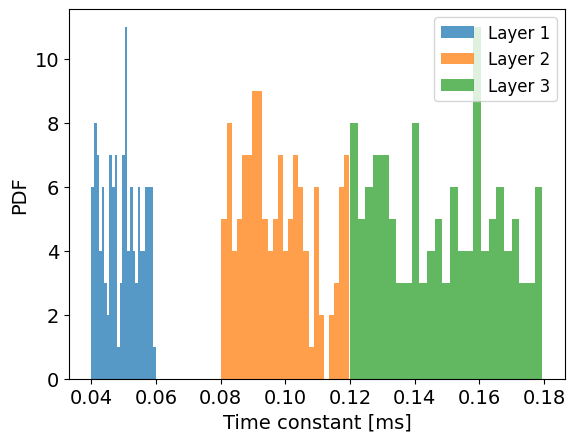

In [22]:
####### PLOT OF THE TIME CONSTANTS (INITIALIZATION)
fig, ax = plt.subplots( )
for n in range(len(net_params)):
    if len(net_params[n][1].shape)>0:
        _ = ax.hist(-args.timestep/ np.log(net_params[n][1]), 25, alpha=0.75, label='Layer '+str(n+1))
ax.set_xlabel( 'Time constant [ms]', size=14 )
ax.set_ylabel( 'PDF', size=14 )
ax.tick_params( labelsize=14 )
ax.legend( prop={'size':12} )

In [24]:
@jit
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states, key, dropout_rate = args_in
    _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # forward pass
    # net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], X)
    # Forward pass throught the whole model
    args_in = [net_params, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, X )
    Yhat = decoder_cum( output_layer )

    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( net_params ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

# initialize parameters
dropout_rate = 0.0
args.seed = 14
args.distrib_tau = True
args.hierarchy_tau = False
args.recurrent = False
args.normalizer = 'batch' #'layer'
args.norm_bias_init = 0.
args.tau_mem = 0.2 #0.1
args.l2_lambda = 0.
args.freq_lambda = 0.
if args.recurrent:
    layer = rlif_step
    model = hrsnn_step
    args.w_scale = [0.075, 0.05]
else:
    layer = lif_step
    model = hsnn_step
    args.w_scale = [1/np.sqrt( args.n_in )] + [1/np.sqrt( args.n_hid )]*(args.n_layers-1)
norm = BatchNorm
args.n_layers = 3


key = jax.random.PRNGKey(seed=args.seed)
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( test_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

net_params, net_states = params_initializer( key, args )

# import pickle
# # params from sparch
# params = pickle.load( open( '/Users/filippomoro/Desktop/params_snn_84p_numpy.pkl', 'rb' ) )
# for i in range( len(net_params) ):
#     if args.normalizer in ['batch', 'layer']:
#         net_params[i][0][0] = params[f'snn.{i}.W.weight'].T
#         net_params[i][1] = params[f'alpha{i}']
#         net_params[i][0][1] = params[f'scale{i}']
#         net_params[i][0][2] = params[f'bias{i}']
#     else:
#         net_params[i][0] = params[f'snn.{i}.W.weight'].T
#         net_params[i][1] = params[f'alpha{i}']


dropout_rate = 0.0
# # testing the training function
# args_ins = [net_params, net_states, key, dropout_rate]
# args_out = scan(model, args_ins, x_train[0], length=args.nb_steps)
# [net_params_hist, net_states_hist] = args_out

args_in = [net_params, net_states, key, dropout_rate]
output_layer, out_spike_net = hsnn( args_in, x_test )
Yhat = decoder_cum( output_layer )

# decoder
# Yhat = jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )
# Yhat_vmax = jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )
# Yhat_cum = jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)
# print( Yhat_cum.shape )

# loss
loss_total, loss_values = loss(key, net_params, net_states, x_test, one_hot(Y, 20), 0)

# values and gradients
value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, net_params, net_states, x_test, one_hot(Y_test,20), 0, dropout_rate=0.0)

Input shape: train (128, 100, 700) - test (128, 100, 700)


In [25]:
n_layers = len( net_params )
# collection of output spikes
out_spike_net_b = []
# Loop over the layers
for l in range(n_layers):
    if l == 0: layer_input_spike = x_test
    else: layer_input_spike = out_spikes_layer
    # making layers' params and states explitic
    # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    if len(weight) ==2: weight, _ = weight
    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(layer_input_spike, weight)
    # Normalization (if selected)
    if len(w) == 3: # it means that we'll do normalization
        b, t, n = I_in.shape
        I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
        I_in = I_in.reshape( b,t,n ) # normalized input current
    # Forward pass of the Layer
    args_in_layer = [net_params[l], net_states[l]]
    if l+1 == n_layers:
        _, out_spikes_layer_b = vscan_layer_out( args_in_layer, I_in )
    else: 
        _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
        # Dropout
        key, key_dropout = jax.random.split(key, 2)
        out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
    out_spike_net_b.append(out_spikes_layer)

In [26]:
jnp.sum( jax.nn.softmax( out_spikes_layer_b, axis=-1 ), axis=1)[0]

Array([5.504156 , 4.0522785, 4.3228045, 3.975809 , 6.000391 , 4.9515777,
       5.8372865, 3.746243 , 7.292494 , 4.624026 , 4.171534 , 3.8599901,
       4.6428614, 4.632159 , 6.5391397, 3.7971606, 4.2611313, 6.2887297,
       6.3179307, 5.1822915], dtype=float32)

In [27]:
jnp.sum( jax.nn.softmax( out_spike_net[-1], axis=-1 ), axis=1)[0]

Array([5.504156 , 4.0522785, 4.3228045, 3.975809 , 6.000391 , 4.9515777,
       5.8372865, 3.746243 , 7.292494 , 4.624026 , 4.171534 , 3.8599901,
       4.6428614, 4.632159 , 6.5391397, 3.7971606, 4.2611313, 6.2887297,
       6.3179307, 5.1822915], dtype=float32)

In [28]:
jnp.abs((out_spike_net[0] - out_spike_net_b[0])).sum()

Array(0., dtype=float32)

In [30]:
# Checking the Gradients on the first layer

net_params, net_states = params_initializer( key, args )

# import pickle
# # params from sparch
# params = pickle.load( open( '/Users/filippomoro/Desktop/params_snn_84p_numpy.pkl', 'rb' ) )
# for i in range( len(net_params) ):
#     if args.normalizer in ['batch', 'layer']:
#         net_params[i][0][0] = params[f'snn.{i}.W.weight'].T
#         net_params[i][1] = params[f'alpha{i}']
#         net_params[i][0][1] = params[f'scale{i}']
#         net_params[i][0][2] = params[f'bias{i}']
#     else:
#         net_params[i][0] = params[f'snn.{i}.W.weight'].T
#         net_params[i][1] = params[f'alpha{i}']

### Computing the first pre-activation with Normalization
def first_layer(net_params, x_test):
    l = 0; layer_input_spike = x_test
    w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    if len(weight) ==2: weight, _ = weight
    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(layer_input_spike, weight)
    # Normalization (if selected)
    if len(w) == 3: # it means that we'll do normalization
        b, t, n = I_in.shape
        I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
        I_in = I_in.reshape( b,t,n ) # normalized input current

    # Forward pass of the Layer
    args_in = [net_params[l], net_states[l]]
    if l+1 == len( net_params ):
        _, out_spikes_layer = vscan_layer_out( args_in, I_in )
    else: 
        _, out_spikes_layer = vscan_layer( args_in, I_in )
    
    return jnp.mean( out_spikes_layer**2 ), out_spikes_layer

value, grads = value_and_grad(first_layer, has_aux=True, argnums=(0))(net_params, x_test)
grads[0][0][1]

Array([0.00076735, 0.00063383, 0.00097814, 0.00055645, 0.00085246,
       0.0014552 , 0.00066718, 0.00067719, 0.00068003, 0.00044435,
       0.00061735, 0.00170687, 0.00038253, 0.00085462, 0.00051275,
       0.0007672 , 0.00067573, 0.00058511, 0.00051962, 0.00108186,
       0.00147061, 0.0004725 , 0.00052765, 0.00142009, 0.00051044,
       0.00079603, 0.00064606, 0.00085672, 0.0009251 , 0.00119561,
       0.00057692, 0.0008034 , 0.00087499, 0.00061073, 0.00051732,
       0.00054059, 0.00089255, 0.0019822 , 0.00101193, 0.00083508,
       0.00071766, 0.00097441, 0.00071568, 0.00154482, 0.0008174 ,
       0.00122004, 0.00086639, 0.00077438, 0.00132074, 0.00054285,
       0.0019906 , 0.00095774, 0.00078799, 0.00099906, 0.00048988,
       0.00050438, 0.00072055, 0.00095875, 0.00040959, 0.0004717 ,
       0.00125962, 0.00110288, 0.00102205, 0.00089684, 0.00055581,
       0.00066929, 0.00043818, 0.00068625, 0.00086503, 0.00119484,
       0.00120707, 0.00050963, 0.00056746, 0.00061006, 0.00119

In [31]:
value[1].sum(axis=(0,1))

Array([1841., 1496., 2706., 1425., 2120., 2726., 1357., 1732., 1748.,
        953., 1390., 3005., 1022., 2497., 1392., 1752., 1696., 1624.,
       1417., 2558., 2813., 1110.,  959., 2756., 1091., 1636., 1732.,
       1980., 2398., 2893., 1690., 1910., 2477., 1821., 1074., 1314.,
       2111., 3304., 2774., 2132., 1812., 2450., 1778., 2923., 1949.,
       2931., 1886., 1918., 2632.,  949., 3343., 2409., 1899., 2852.,
        896.,  845., 1640., 2166., 1171., 1121., 2551., 2628., 2515.,
       2086., 1265., 1340., 1109., 1677., 2206., 2536., 2456., 1100.,
       1318., 1265., 2435., 3011., 3183., 1580., 1272., 1162., 2368.,
       2050., 1266., 1533., 1144., 1218.,  905., 1792., 2072.,  928.,
       2536., 1447., 2435., 2476., 1437., 2704., 1748., 2179., 1948.,
       1821., 1275., 2312., 2279., 2255., 1564., 1096., 2554., 1251.,
       2442., 2916., 1831., 1168., 2754., 2865., 2289., 1210., 1598.,
        970., 1499.,  931., 1574.,  931., 1896., 2230., 1221., 1070.,
       2989., 2451.]

In [32]:
### Computing the first pre-activation with Normalization
def second_layer(net_params, x_test):
    l = 1; layer_input_spike = x_test
    w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    if len(weight) ==2: weight, _ = weight
    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(layer_input_spike, weight)
    # Normalization (if selected)
    if len(w) == 3: # it means that we'll do normalization
        b, t, n = I_in.shape
        I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
        I_in = I_in.reshape( b,t,n ) # normalized input current

    # Forward pass of the Layer
    args_in = [net_params[l], net_states[l]]
    if l+1 == len( net_params ):
        _, out_spikes_layer = vscan_layer_out( args_in, I_in )
    else: 
        _, out_spikes_layer = vscan_layer( args_in, I_in )
    
    return jnp.mean( out_spikes_layer**2 ), out_spikes_layer

value_2nd, grads = value_and_grad(second_layer, has_aux=True, argnums=(0))(net_params, value[1])
grads[1][0][1]

Array([0.00093607, 0.00145668, 0.00127759, 0.00121363, 0.00093815,
       0.00098057, 0.00073845, 0.00119019, 0.00096742, 0.00076319,
       0.00214508, 0.00073202, 0.00170945, 0.0015956 , 0.0009381 ,
       0.00140231, 0.00111321, 0.00095307, 0.00111712, 0.00151042,
       0.00124079, 0.00082157, 0.00099836, 0.00160323, 0.00137172,
       0.00084297, 0.00186251, 0.00120335, 0.00135386, 0.00111624,
       0.00087388, 0.00243268, 0.00147205, 0.0010989 , 0.00081691,
       0.00289969, 0.00126891, 0.00138916, 0.0008288 , 0.00120576,
       0.00174194, 0.00084663, 0.00074009, 0.00115459, 0.00111908,
       0.00105559, 0.00084274, 0.00148386, 0.00147913, 0.00218714,
       0.00102801, 0.00090773, 0.00187288, 0.00106426, 0.00094484,
       0.00114213, 0.00137229, 0.00105295, 0.0005389 , 0.00134609,
       0.00190055, 0.00138249, 0.00116696, 0.00104026, 0.00163596,
       0.00164523, 0.00102256, 0.00107317, 0.00094486, 0.00076259,
       0.0013805 , 0.00142811, 0.00223596, 0.00122479, 0.00091

In [33]:
value_2nd[1].sum( axis=(0,1) )

Array([2116., 2220., 2376., 1787., 1938., 1718., 1257., 1908., 1875.,
       1438., 2966., 1459., 2365., 2282., 1834., 2176., 2831., 2052.,
       1784., 2298., 1793., 1383., 1786., 2319., 2028., 1470., 2583.,
       2368., 1924., 1704., 1471., 3168., 2155., 2795., 1932., 3759.,
       1910., 2476., 1639., 2347., 2957., 1343., 1618., 2535., 1627.,
       2158., 1491., 2475., 2125., 2979., 1687., 1501., 3221., 1932.,
       1550., 1884., 2080., 2873., 1609., 2739., 2612., 1998., 2555.,
       2578., 2408., 2363., 1658., 2576., 1815., 1690., 1896., 2067.,
       2980., 2681., 1774., 1609., 2312., 1427., 2476., 2506., 3028.,
       3379., 3098., 1640., 2076., 1857., 2226., 3291., 2395., 2394.,
       2713., 2514., 1985., 3354., 1962., 2630., 2891., 1583., 2596.,
       2099., 1882., 1678., 3212., 2348., 2058., 3390., 2587., 1543.,
       2175., 2180., 2160., 2896., 2110., 2814., 2189., 2299., 2701.,
       1948., 1816., 1769., 2775., 2811., 1737., 2478., 1398., 2069.,
       2833., 1966.]

In [34]:
### Computing the first pre-activation with Normalization
def third_layer(net_params, x_test):
    l = 2; layer_input_spike = x_test
    w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    if len(weight) ==2: weight, _ = weight
    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(layer_input_spike, weight)
    # Normalization (if selected)
    if len(w) == 3: # it means that we'll do normalization
        b, t, n = I_in.shape
        I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
        I_in = I_in.reshape( b,t,n ) # normalized input current

    # Forward pass of the Layer
    args_in = [net_params[l], net_states[l]]
    if l+1 == len( net_params ):
        _, out_spikes_layer = vscan_layer_out( args_in, I_in )
        out_spikes_layer = jnp.sum( jax.nn.softmax( out_spikes_layer, axis=-1 ), axis=1)
    else: 
        _, out_spikes_layer = vscan_layer( args_in, I_in )
    
    return jnp.mean( out_spikes_layer**2 ), out_spikes_layer

value_3rd, grads = value_and_grad(third_layer, has_aux=True, argnums=(0))(net_params, value_2nd[1])
grads[2][0][1]

Array([-0.00517766,  0.01526389,  0.01000238,  0.1457658 ,  0.09596697,
        0.0159039 , -0.00985695,  0.04546271,  0.02727821,  0.01400958,
        0.01759365, -0.01035395,  0.01177882,  0.03090918,  0.00503275,
        0.02642335,  0.01599982,  0.03837876,  0.03031916,  0.0291216 ],      dtype=float32)

In [35]:
value_3rd[1][0]

Array([4.0918617, 6.176214 , 6.649568 , 4.9560757, 5.0084147, 4.631906 ,
       4.8350964, 3.8296063, 4.014703 , 6.277969 , 6.2531676, 4.3820057,
       4.766175 , 4.4839563, 5.495924 , 4.823924 , 3.942988 , 6.9296145,
       4.6212134, 3.8296063], dtype=float32)

-4.7723984e-06 0.021833293
-0.00047378277 0.050812863
0.0007956222 0.05092877


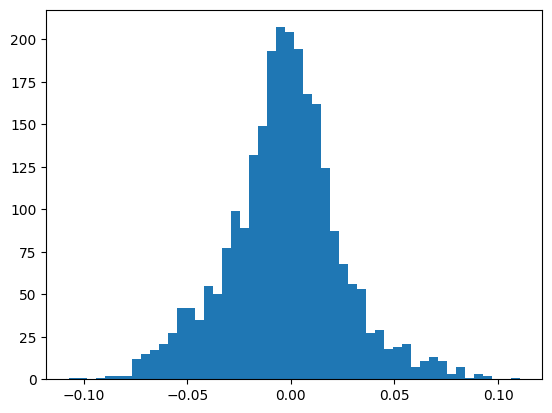

In [36]:
for i in range( args.n_layers ):
    print( net_params[i][0][0].mean(), net_params[i][0][0].std() )

_ = plt.hist( grads[2][0][0].flatten(), 50 )

In [37]:
jnp.mean( out_spike_net[0], axis=(0,1,2) ), jnp.mean( out_spike_net[1], axis=(0,1,2) )

(Array(0.14742431, dtype=float32), Array(0.16816773, dtype=float32))

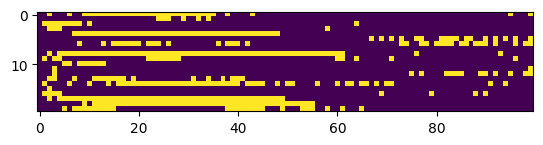

In [38]:
plt.imshow( out_spike_net[2][0].T )

### Training Loop
---

In [ ]:
args.train_alpha = True
args.hierarchy_tau = False
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
args.normalizer = 'batch' # 'batch' #'layer'
args.norm_bias_init = 0.0
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: 
    model = hrsnn_step
    layer = rlif_step
else: 
    model = hsnn_step
    layer = lif_step
layer_out = li_step
args.n_layers = 4
args.n_hid = 128
# time constants
args.tau_mem = 0.1 #0.1
delta_tau = 0.1
args.tau_end = args.tau_mem + delta_tau
args.tau_start = args.tau_mem - delta_tau
args.distrib_tau_sd = 0.2
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.2 #0.014*5 # 0.21 #0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05] #[[3*np.sqrt(1/args.n_in), 2*np.sqrt(1/args.n_hid)], [2*np.sqrt(1/args.n_hid), 2*np.sqrt(1/args.n_hid)], [2*np.sqrt(1/args.n_hid), 2*np.sqrt(1/args.n_hid)] ] #[0.075, 0.05]
else : args.w_scale = [ 1*np.sqrt(1/args.n_in), 1*np.sqrt(1/args.n_hid), 1*np.sqrt(1/args.n_hid) ] #[0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.01
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
n_epochs = 20

train_loss, test_acc_shd, val_acc_shd, net_params_trained = train_hsnn(key = jax.random.PRNGKey(args.seed), n_epochs=n_epochs, args = args, 
                                                            train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                            param_initializer=params_initializer,
                                                            noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=True)

In [ ]:
for i in range(args.n_layers-1):
    _ = plt.hist( net_params_trained[i][1], 25, alpha=0.6, label=f'Layer {i}' )
    print( np.mean(  net_params_trained[i][1] ) )
plt.legend()

# Debug the time constant training

In [1]:
from models import *
from utils_initialization import *
from training import *

In [2]:
# load dataloader
train_dl, val_dl, test_dl = get_dataloader( args=args, verbose=True )

# Layer and Layer out could be different in general (output might not be spiking)
# so the two following function scan the lyers and jit for speed
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

# the following function implements the main network
@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in # input arguments
    n_layers = len( net_params )                        # umber of layers
    # collection of output spikes
    out_spike_net = [] # collects the spikes from each layer
    # Loop over the layers
    for l in range(n_layers):
        # selecting the right input (from the previous layer)
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # Multiplying the weights by the spikes
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in_layer = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in_layer, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in_layer, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net

# selecting the right decoder
decoder_dict = {'cum'  : decoder_cum,
                'sum'  : decoder_sum,
                'vmax' : decoder_vmax,
                'vlast': decoder_vlast,
                'freq' : decoder_freq
                }
if args.decoder in decoder_dict.keys():
    decoder = decoder_dict[args.decoder]
else: 
    print('Unrecognized Decoder, will revert to a "cum"-style decoder')
    print('Next time choose a decoder in: '+str(list(decoder_dict.keys())))
    args.decoder = 'cum'
    decoder = decoder_dict[args.decoder]

# network architecture
if args.recurrent:
    layer = rlif_step
else: 
    layer = lif_step
if args.decoder == 'freq':
    layer_out = lif_step
else: 
    layer_out = li_step
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None

# Randon Number Generator
key = jax.random.PRNGKey(args.seed)
key, key_model = jax.random.split(key, 2)

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.0):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # Forward pass throught the whole model
    args_in = [net_params, net_states, key, dropout_rate]
    output_layer, out_spike_net = hsnn( args_in, X )
    Yhat = decoder( output_layer )
    # Yhat = jax.nn.softmax( net_states_hist[-1][3][:,-1] )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( [net_params[l][0] for l in range(len(net_params))] ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    # Total loss
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

I0000 00:00:1711026490.544184       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


In [1]:
from models import *
from utils_initialization import *
from training import *

In [2]:
args.train_alpha = True
args.hierarchy_tau = False
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
# args.normalizer = 'batch' # 'batch' #'layer'
args.n_layers = 4
# time constants
args.tau_mem = 0.1 #0.1
args.delta_tau = 0.075

# LR and regularizers
if args.recurrent: args.lr = 0.01
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 #1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
args.n_epochs = 1

# Training
train_loss, test_acc, val_acc, net_params_best = train_hsnn( args = args, dataset_name='shd' )

I0000 00:00:1711023786.458083       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264
-1.1194398 -0.21651754 -0.082665324 -0.04161041 -0.23506558
1.1295465 -0.098080754 -0.0826854 -0.046741433 -0.10153714
-2.4821854 -0.105574146 -0.065090254 -0.048953973 -0.03142652
-3.4464393 -0.1702151 -0.03427635 -0.04596042 -0.010633167
-1.8379662 -0.10720667 -0.064506374 -0.037086383 -0.009506467
-0.21725273 -0.07429467 -0.11271085 -0.27280793 -0.0071450714
-0.81926024 -0.13349967 -0.054480597 -0.26439434 -0.008702176
-1.3624287 -0.193813 -0.1686931 -0.21466324 -0.010759732
-0.3777742 -0.15402673 -0.11919673 -0.2966145 -0.012980745
-0.6734398 -0.42052332 -0.1600038 -0.26202548 -0.012800033
-0.3776545 -0.42660993 -0.16251577 -1.2845031 -0.03357714
0.65710306 -0.52836794 -0.14227135 -0.82841116 -0.019317469
0.5221428 -0.2142136 -0.42354837 -0.75866836 -0.031482592
-0.7487883 -0.18232313 -0.2606839 -0.28345275 -0.06681553
0.04717085 -0.31063274 -0.29201946 -0.73776805 -0.009923074
0.94321746 -0.28223735 -0.25852332 -0.6

In [4]:
net_params_best[3][1]

0.2

In [4]:
args.train_alpha = True
net_params, net_states = params_initializer( key_model, args )
X, Y = next( iter( train_dl ) )
Y = one_hot( Y, 20 )
value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, net_params, net_states, X, Y, 0, dropout_rate=0.)

In [15]:
value

(Array(3.8401248, dtype=float32),
 [Array(3, dtype=int32), Array(3.8401248, dtype=float32)])

In [19]:
grads[0][1].argmin(), grads[0][1].min()

(Array(102, dtype=int32), Array(-0.15023588, dtype=float32))

In [18]:
net_params_best[-1][1] + grads[-1][1].min()

Array(-0.28497142, dtype=float32)

# Temporal and Causal Convolution
---


In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, pmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="1"
jax.devices()

[cuda(id=0)]

In [5]:
from utils_initialization import SimArgs
from utils_dataset import get_dataloader
from utils_initialization import params_initializer
# arguments for importing dataset
args = SimArgs( convolution=True )
args.conv_kernel = 5
args.delta_ker = 3
args.n_layers = 3
args.conv_dilation = 5
args.hierarchy_conv = 'kernel'

In [6]:
key = jax.random.PRNGKey(args.seed)
net_params, net_states = params_initializer( key, args )

In [7]:
args.conv_kernels

array([3, 6, 5])

In [8]:
for i in range(len(net_states)):
    print( net_states[0][-1] )

5
5
5


In [4]:
net_params[0][0][0].shape

(7, 700, 128)

In [43]:
from utils_initialization import SimArgs
from utils_dataset import get_dataloader

# arguments for importing dataset
args = SimArgs()
args.dataset_name = 'shd'
args.nb_steps = 250
args.n_in = 700


#importing the dataset
train_dl, val_dl, test_dl = get_dataloader( args=args, verbose=True )
x, y = next(iter(train_dl))

Train DL size: 6524, Validation DL size: 1632, Test DL size: 2264


In [44]:
x.shape

(256, 250, 700)

In [45]:
def frequency_shift( input, freq_shift=20, p_top=0.5 ):
    '''We take the original dataset (700) inputs and pad either the top or bottom with zeros, then cropping the exceeding frequency channels
    - frequency_shift : number of channels to shift up or down
    - p_top           : probability to add the frequency shit from the top (= 1 - p_bot) 
    '''
    up_idx = np.random.uniform( size=input.shape[0] ) >= p_top
    input_padded = np.copy(input)
    input_padded[up_idx] = np.pad( input[up_idx], ((0,0),(0,0),(freq_shift,0)) )[:,:,:input.shape[2]]
    input_padded[~up_idx] = np.pad( input[~up_idx], ((0,0),(0,0),(0,freq_shift)) )[:,:,freq_shift:]
    return input_padded

In [49]:
x_shift = frequency_shift(x, freq_shift=25)

Text(0.5, 1.0, 'original')

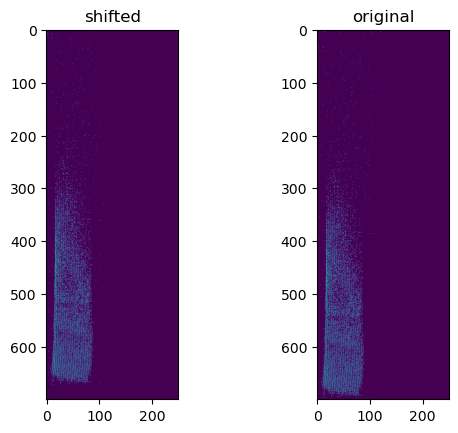

In [52]:
fig, ax = plt.subplots(1,2)
idx = 3
ax[0].imshow( x_shift[idx].T )
ax[0].set_title('shifted')
ax[1].imshow( x[idx].T, )
ax[1].set_title('original')

In [1]:
700*128*2 + (128**2)*4 + (128**2)*6 + 128*20

345600

In [1]:
700*256*3 + (256**2)*4 + (256**2)*6 + 256*20

1198080

In [62]:
dilation = 5
dilation_deltas = [-3, -2, -1, 0, 1, 2, 3]
n_layers = 8

[ [int(dilation + ((n_layers-2)**-1)*(l-(n_layers-2)/2)*dilation_delta) for l in range(n_layers-1)] for dilation_delta in dilation_deltas]

[[6, 6, 5, 5, 4, 4, 3],
 [6, 5, 5, 5, 4, 4, 4],
 [5, 5, 5, 5, 4, 4, 4],
 [5, 5, 5, 5, 5, 5, 5],
 [4, 4, 4, 5, 5, 5, 5],
 [4, 4, 4, 5, 5, 5, 6],
 [3, 4, 4, 5, 5, 6, 6]]

In [38]:
def Conv1D_causal( x, weight, dilation=3 ):
    '''1D Convolution using jax.lax.conv_general_dilated
    from https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.conv_general_dilated.html
    x: the input data              [Batch, Length (height), Channels]
    weight: the convolution filter [Kernel size (height), Input channels, Output channels]
        (note: both inputs should be in jnp.float32 type)
    As this is a convolution Causal (only the past influences the future) the input is padded in 
    the left part (beginning) of the input sequence by the same size of the kernel.
    '''
    # turn inputs to the right data-type
    x = x.astype( jnp.float32 )
    # padding for making Conv1D causal
    pad_size = ( (weight.shape[0]-1) * dilation ) +1
    x = jnp.pad( x, pad_width=((0,0),(pad_size-1,0),(0,0)), constant_values=0. )
    # dimention number --> ordering the data for the convolution
    dims=("NHC", "HIO", "NHC")
    rhs_dilation = [dilation]
    return jax.lax.conv_general_dilated( lhs=x, rhs=weight, window_strides=[1], 
                                         padding='valid', dimension_numbers=dims,
                                         rhs_dilation=rhs_dilation )

In [39]:
# weight = jnp.ones( (15, 250, 32) )
weight = net_params[0][0][0]
out = Conv1D_causal( x, weight=weight )
out.shape

(256, 100, 128)